In [1]:
# append AQUA directory to sys.path
import sys
import os
sys.path.append("..\\") # parent directory
from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from plotting_functions import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import pickle
from tqdm import tqdm   # for a progress bar
import seaborn as sns
sns.set_theme(style = "white")

# local imports
import CLI
import CF
from functions import *


## RS Resonator

In [2]:
# param
RS = {'name': 'RS_resonator', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
     'a': 0.03, 'b': 5, 'c': -50, 'd': 100, 'e': 0.0, 'f': 0.0, 'tau': 0.0}    # Class 1

f_vals = np.arange(-250, 251, 50)
idx_0 = np.argwhere(f_vals == 0)
f_vals = f_vals[np.r_[0:idx_0, idx_0+1:len(f_vals)]]
e_vals = np.arange(0.1, 0.5, 0.1)
tau_vals = np.array([0, 0.5, 2, 4])

params = []
params.append(RS)
for f in f_vals:
    for e in e_vals:
        for tau in tau_vals:
            temp_dict = RS.copy()
            temp_dict['f'] = f
            temp_dict['e'] = e
            temp_dict['tau'] = tau
            params.append(temp_dict)

param_df = pd.DataFrame(params)

# NOW params contains all the parameter values we need.
print(len(params))

threshold, x_ini = find_threshold(params[0], np.linspace(0, 500, 100), 2, 0.1)
base_current = threshold + 25 # + 10 for integrator

161


100%|██████████| 19999/19999 [00:02<00:00, 7571.86it/s]


In [3]:
## Simulation parameters

Time = 1
dt = 0.01
N_iter = int(1000*Time/dt)

N_neurons = np.shape(params)[0]

I_inj = base_current*np.ones((N_neurons, N_iter))

x_start = np.full((N_neurons, 3), fill_value = x_ini)
t_start = np.zeros(N_neurons)


batch = batchAQUA(params)
batch.Initialise(x_start, t_start)

# Add new columns to the dataframe
net_aut_currents = batch.get_net_autapse_currents()
mean_aut_delays = batch.get_mean_autapse_delays()
#print(len(net_aut_currents))
param_df.insert(len(param_df.columns), column = "net autapse currents", value = net_aut_currents)
param_df.insert(len(param_df.columns), column = "mean autapse delays", value = mean_aut_delays)


X, T, spikes = batch.update_batch(dt, N_iter, I_inj)

100%|██████████| 99999/99999 [00:15<00:00, 6453.47it/s]


161
Index([  1,   2,   3,   4,  20,  19,  18,  17,  36,  35,
       ...
       113, 132, 131, 130, 129, 145, 146, 147, 148,   0],
      dtype='int64', length=161)
2500.0
nan


Text(0.5, 1.0, 'Effect of the net autapse current on firing rate')

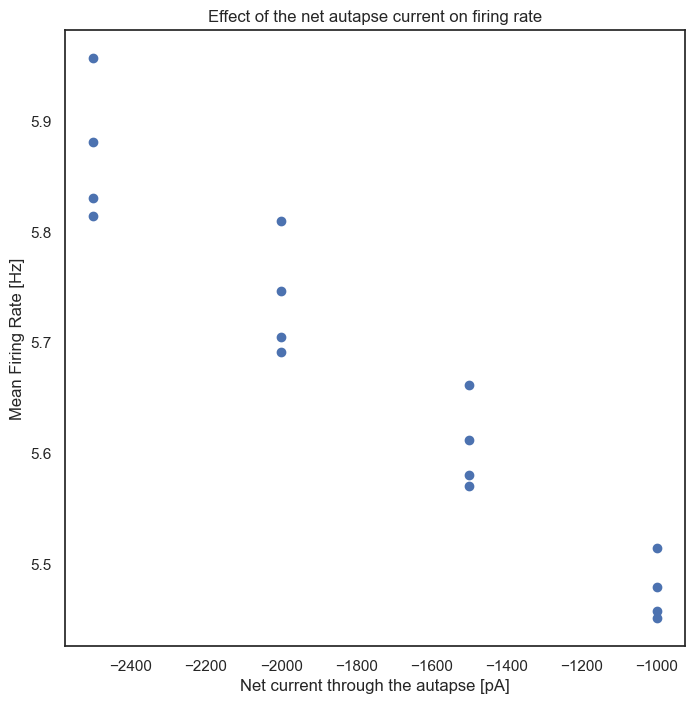

In [14]:
# extract mean firing frequency (i.e. num spikes / T) -> spikes/sec
fire_rate = np.zeros(N_neurons)
print(len(spikes))
for i in range(len(spikes)):    # loop over rows
    fire_rate[i] = 1000/np.mean(np.diff(spikes[i]))

# plot firing frequency versus net injected current.

sort_order = param_df.sort_values(by=["net autapse currents"]).index
print(sort_order)
print(np.max(param_df["net autapse currents"]))
print(fire_rate[sort_order][-2])

fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.scatter(param_df["net autapse currents"][sort_order], fire_rate[sort_order])
ax.set_xlabel("Net current through the autapse [pA]")
ax.set_ylabel("Mean Firing Rate [Hz]")
ax.set_title("Effect of the net autapse current on firing rate")
